In [1]:
import matplotlib.pyplot as plt
from SpatialAxis.spatial_axis import spatial_axis_to_labelmap
from SpatialAxis import spatial_axis
from SpatialAxis.utility import random_shapely_circles, create_broad_annotation_polygons
import geopandas
from rasterio.features import rasterize
import numpy as np
import numpy
import warnings
import scipy
import typing

,geometry
0,"POLYGON ((114.542 243.383, 114.452 241.554, 11..."
1,"POLYGON ((169.037 39.941, 168.961 38.394, 168...."
2,"POLYGON ((32.875 221.741, 32.788 219.976, 32.5..."
3,"POLYGON ((201.116 5.27, 201.021 3.324, 200.735..."
4,"POLYGON ((229.014 54.359, 228.938 52.799, 228...."
...,...
495,"POLYGON ((112.291 101.42, 112.203 99.609, 111...."
496,"POLYGON ((115.659 114.866, 115.581 113.279, 11..."
497,"POLYGON ((110.918 58.181, 110.844 56.675, 110...."
498,"POLYGON ((172.58 171.062, 172.493 169.289, 172..."


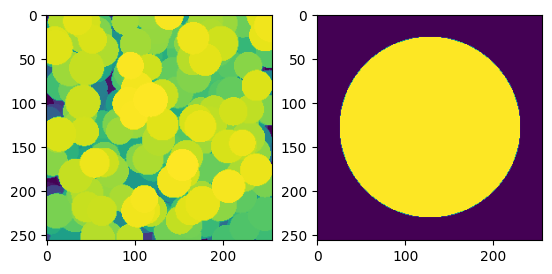

In [2]:
IMG_SHAPE = (256, 256)

shapes = random_shapely_circles(
    image_shape=IMG_SHAPE, 
    num_circles=500,
    min_radius=15,
    max_radius=20,
    seed=42,
    )

labeled_polygons = [(polygon, idx + 1) for idx, polygon in enumerate(shapes)]
labeled_array = rasterize(
    [(poly, label) for poly, label in labeled_polygons], 
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

broad_annotations = create_broad_annotation_polygons(image_shape=IMG_SHAPE, annotation_shape="circle")
labeled_broad_annotations = [(polygon, idx + 1) for idx, polygon in enumerate(broad_annotations)]
labeled_broad_annotations = rasterize(
    [(poly, label) for poly, label in labeled_broad_annotations], 
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(labeled_array)
ax[1].imshow(labeled_broad_annotations)

shapes = geopandas.GeoDataFrame(geometry=shapes)
broad_df = geopandas.GeoDataFrame(
    {
        "geometry": broad_annotations,
        "broad_annotation_id": ["edge", "cortex", "medulla"],
    }
)
broad_df = broad_df.set_index("broad_annotation_id")
shapes

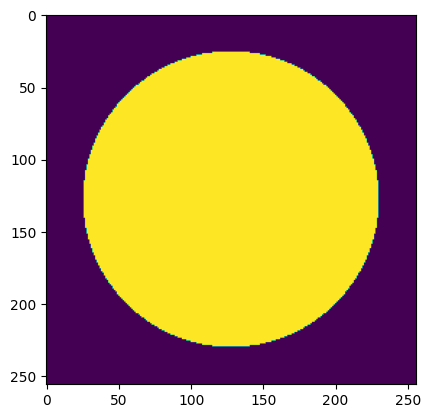

In [14]:
t = rasterize(
    [broad_annotations[2]], 
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

fig, ax = plt.subplots()
ax.imshow(t)

256


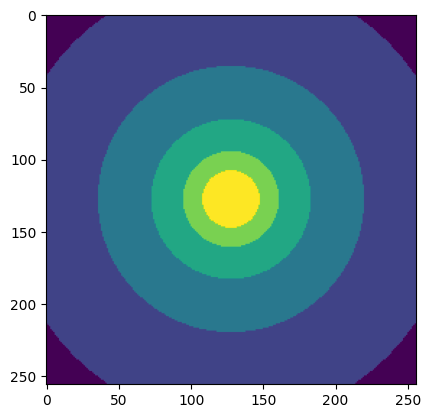

In [108]:
import shapely

def create_broad_annotation_polygons(
    image_shape: typing.Tuple[int, int],
    annotation_shape: typing.Literal["box", "circle"] = "box",
    num_levels: int = 3,
    downscale_factor: float = 0.6
) -> typing.Tuple[shapely.geometry.Polygon]:
    """Create 3 shapely box polygons, each containing the next smallest object.

    Args:
        image_shape (typing.Tuple[int, int]): Size of array to draw polygons in.

    Returns:
        typing.Tuple[shapely.geometry.Polygon]: Outer, middle and inner polygons.
    """

    assert num_levels > 2, f"num_levels must be > 2, got {num_levels}"

    minx, miny, maxx, maxy = 0, 0, image_shape[1], image_shape[0]

    if annotation_shape.casefold() == "box":
        outer = shapely.geometry.box(minx, miny, maxx, maxy)
    elif annotation_shape.casefold() == "circle":
        print(max(maxx, maxy))
        outer = shapely.geometry.Point(maxx / 2, maxy / 2).buffer(max(maxx, maxy))

    shapes = [outer]

    for level in range(num_levels - 1):
        # Scale the previous polygon by the scale_factor
        scaled_shape = shapely.affinity.scale(shapes[level], downscale_factor, downscale_factor)
        # Find the difference of the original shape and the scaled shape
        prev_shape = shapely.difference(shapes[level], scaled_shape)
        # Add the difference shape to ith position
        shapes[level] = prev_shape
        # Add the scaled shape (no difference) to the i+1th position
        shapes.append(scaled_shape)

    return shapes

NUM_BROAD_ANNOTATION = 6

broad_annotations = create_broad_annotation_polygons(
    image_shape=IMG_SHAPE, 
    annotation_shape="circle",
    num_levels=NUM_BROAD_ANNOTATION,
    )
broad_df = geopandas.GeoDataFrame(
    {
        "geometry": broad_annotations,
        "broad_annotation_id": np.arange(NUM_BROAD_ANNOTATION),
    }
)
broad_df = broad_df.set_index("broad_annotation_id")
labeled_broad_annotations = [(polygon, idx + 1) for idx, polygon in enumerate(broad_annotations)]

t = rasterize(
    # [broad_annotations[1]], 
    [(poly, label) for poly, label in labeled_broad_annotations], 
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

fig, ax = plt.subplots()
ax.imshow(t)

In [109]:
shapes["spatial_axis"] = spatial_axis(
    shapes,
    broad_df,
    np.arange(NUM_BROAD_ANNOTATION),
    k_neighbours=5
)

shapes

,geometry,spatial_axis
0,"POLYGON ((114.542 243.383, 114.452 241.554, 11...",-0.386134
1,"POLYGON ((169.037 39.941, 168.961 38.394, 168....",0.021470
2,"POLYGON ((32.875 221.741, 32.788 219.976, 32.5...",-0.662619
3,"POLYGON ((201.116 5.27, 201.021 3.324, 200.735...",-0.485136
4,"POLYGON ((229.014 54.359, 228.938 52.799, 228....",-0.480188
...,...,...
495,"POLYGON ((112.291 101.42, 112.203 99.609, 111....",0.499260
496,"POLYGON ((115.659 114.866, 115.581 113.279, 11...",0.698153
497,"POLYGON ((110.918 58.181, 110.844 56.675, 110....",0.108241
498,"POLYGON ((172.58 171.062, 172.493 169.289, 172...",0.410108


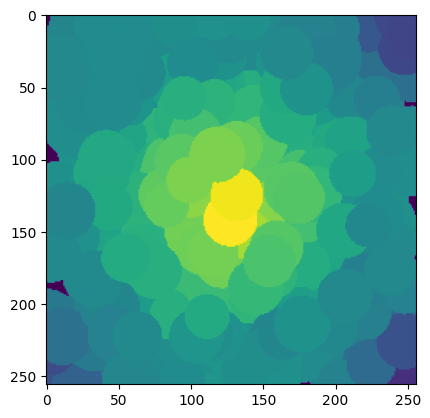

In [110]:
relative_array = spatial_axis_to_labelmap(
    shapes,
    IMG_SHAPE,
    background_value=-2
)

fig, ax = plt.subplots()
ax.imshow(relative_array)